<img align='center' style='max-width: 1000px' src='banner.png'>

<img align='right' style='max-width: 200px; height: auto' src='hsg_logo.png'>

## Lab 09 - Generative Adversarial Networks (GANs)

GSERM Summer School 2024, Deep Learning: Fundamentals and Applications, University of St. Gallen

The lab environment is based on Jupyter Notebooks (https://jupyter.org), which provide an interactive platform for performing a variety of statistical evaluations and data analyses. In this lab, we will learn how to apply a deep learning technique referred to as **Generative Adversarial Networks (GANs)**. Unlike standard feedforward neural networks, GANs consist of two networks, a generator and a discriminator, which are trained together in a game-theoretic framework to generate realistic synthetic data.

GANs were introduced by *Ian Goodfellow* and his colleagues in 2014 and have since revolutionized the field of generative modeling. They are capable of generating high-quality data across various domains, including images, text, and audio. The generator network creates synthetic data, while the discriminator network attempts to distinguish between real and synthetic data. Through this adversarial process, the generator improves its ability to create realistic data over time.

In this lab, we will use the `PyTorch` library to implement and train a **Generative Adversarial Networks**. The network will be trained on the Fashion-MNIST dataset, which consists of grayscale images of various fashion items. Once the network is trained, we will evaluate its performance by visually inspecting the quality of the generated images. 

The figure below illustrates a high-level view of the machine learning process we aim to establish in this lab.

<img align="center" style="max-width: 800px" src="gan_pipeline.png">

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our CANVAS (StudyNet) forum (https://learning.unisg.ch), or send us an email (using the course email).

## 1. Lab Objectives

After today's lab, you should be able to:

> 1. **Understand Generative Adversarial Network (GAN) Design:** Learn the fundamental concepts and architectural design of GANs.
> 2. **Implement and Train a GAN Model:** Gain hands-on experience with PyTorch to implement, train, and evaluate GAN models.
> 3. **Apply GAN Models to Generate Synthetic Data:** Use GANs to generate realistic fashion images using the Fashion-MNIST dataset.
> 4. **Evaluate and Interpret Model Performance:** Evaluate the GAN model's performance using relevant metrics and interpret the generated results.
> 5. **Visualize and Interpret Generated Images:** Visualize the images generated to gain insights into the model's ability to capture the underlying data distribution.

Before we start let's watch a motivational video:

In [1]:
from IPython.display import YouTubeVideo
# Aiva: "I am AI - AI Composed Music by AIVA"
# YouTubeVideo('Emidxpkyk6o', width=800, height=600)

## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import several Python libraries that facilitate data analysis and visualization. We will primarily use `PyTorch`, `NumPy`, `Scikit-learn`, `Matplotlib`, `Seaborn`, and a few utility libraries throughout this lab.

We start by importing `numpy` and utility libraries. Here, we also import the `pickle` module to save and reuse some Python objects. `pickle` "serializes" an object before writing it to a file. An object can be converted to a character stream and then reconstructed either later on in the script, or in another script.

In [2]:
# import standard python libraries
import os
import datetime as time
from datetime import datetime
import numpy as np
import pickle as pkl

Importing `PyTorch` data download and transform libraries:

In [3]:
# import PyTorch datasets and transforms
import torchvision.datasets as datasets
from torchvision import transforms

Import `Python` machine learning and deep learning libraries:

In [4]:
# import the PyTorch deep learning library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Import the `Matplotlib` data visualization library:

In [5]:
# import matplotlib data visualization library
import matplotlib.pyplot as plt

Enable inline plotting with `Matplotlib`:

In [6]:
%matplotlib inline

Create notebook folder structure to store the data as well as the trained neural network models:

In [27]:
# create the data sub-directory
data_directory = './data_gan'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create the models sub-directory
models_directory = './models_gan'
if not os.path.exists(models_directory): os.makedirs(models_directory) 

Set a random `seed` value to obtain reproducible results:

In [28]:
# init deterministic seed
seed_value = 123
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

Google Colab provides free GPUs for running notebooks. However, if you execute this notebook as is, it will use your device's CPU. To run the lab on a GPU, go to `Runtime` > `Change runtime type` and set the Runtime type to `GPU` in the drop-down menu. Running this lab on a CPU is fine, but you will find that GPU computing is faster. *CUDA* indicates that the lab is being run on a GPU.

Enable GPU computing by setting the device flag and initializing a CUDA seed:

In [29]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


Let's determine if we have access to a GPU provided by environments such as `Google Colab`:

In [30]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## 3. Dataset Download and Data Assessment

In this lab, we will use the popular **FashionMNIST** dataset, which you have already seen in lab 04 **"Artificial Neural Networks (ANNs)"**. Back then, we used the dataset to train a simple neural network to classify the fashion articles. In this lab, we are going to train a model - consisting of 2 networks - to create its own images, based on the **FashionMNIST** items.

The **Fashion-MNIST database** is a large dataset of Zalando articles commonly used for training various image processing systems. The database is widely used for training and testing in the field of machine learning. Let's take a brief look at a few sample images from the dataset:

<img align="center" style="max-width: 500px; height: 300px" src="FashionMNIST.png">

Source: https://www.kaggle.com/c/insar-fashion-mnist-challenge

Further details on the dataset can be obtained from Zalando Research's [GitHub page](https://github.com/zalandoresearch/fashion-mnist).

The **Fashion-MNIST database** is an image dataset of Zalando's article images, consisting of **70,000 images** in total. The dataset is divided into **60,000 training examples** and **10,000 evaluation examples**. Each example is a **28x28 grayscale image**, associated with a **label from 10 classes**. Zalando created this dataset to replace the popular **MNIST** handwritten digits dataset. It is a useful addition as it is a bit more complex but still very easy to use. It shares the same image size and train/test split structure as MNIST, making it a drop-in replacement. It requires minimal efforts in preprocessing and formatting the distinct images.

Let's download, transform and inspect the training images of the dataset. Therefore, let's first define the directory in which we aim to store the training data:

In [31]:
train_path = data_directory + '/train_fmnist'

Now, let's download the training data accordingly:

In [32]:
# define pytorch transformation into tensor format
transf = transforms.Compose([transforms.ToTensor()])

# download and transform images
fashion_mnist_data = datasets.FashionMNIST(root=train_path, train=True, transform=transf, download=True)

100%|███████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:00<00:00, 106596651.87it/s]


Extracting ./data_gan/train_fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data_gan/train_fmnist/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 3215785.60it/s]

Extracting ./data_gan/train_fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data_gan/train_fmnist/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 31838873.27it/s]

Extracting ./data_gan/train_fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data_gan/train_fmnist/FashionMNIST/raw


100%|█████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5270265.31it/s]

Extracting ./data_gan/train_fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_gan/train_fmnist/FashionMNIST/raw



Verify the number of training images downloaded:

In [33]:
# determine the number of training data images
len(fashion_mnist_data)

60000

Next, let's inspect a few of the downloaded training images:

In [34]:
# select and set a (random) image id
image_id = 7779

# retrieve image exhibiting the image id
fashion_mnist_data[image_id]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.2039, 0.5412, 0.3922, 0.3608, 0.3333, 0.3059, 0.3059, 0.3569,
           0.3412, 0.4118, 0.4784, 0.1098, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.5961, 0.7647, 0.7686, 0.8431, 1.0000, 0.9373, 0.8471, 0.8824,
           0.7765, 0.6980, 0.6824, 0.4392, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.6588, 0.6078, 0.5569, 0.5961, 0.7569, 0.7255, 0.8078, 0.6314,
           0.5373, 0.5529, 0.5569, 0.5686, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2157,
           0.7961, 0.6000, 0.6196, 0.6000, 0.7569, 0.5373, 0.6392, 0.7490,
           0.5294, 0.6157, 0.5765, 0.6627, 

Ok, that doesn't seem right. Let's now separate the image from its label information:

In [35]:
fashion_mnist_image, fashion_mnist_label = fashion_mnist_data[image_id]

We can verify the label of our selected image:

In [36]:
fashion_mnist_label

1

Ok, we know that the numerical label is 6. Each image is associated with a label from 0 to 9, representing one of the fashion items. So what does 6 mean? Is it a bag? A pullover? 

The order of the classes can be found on Zalando Research's [GitHub page](https://github.com/zalandoresearch/fashion-mnist). We need to map each numerical label to its fashion item, which will be useful throughout the lab:

In [37]:
fashion_classes = {0: 'T-shirt/top',
                    1: 'Trouser',
                    2: 'Pullover',
                    3: 'Dress',
                    4: 'Coat',
                    5: 'Sandal',
                    6: 'Shirt',
                    7: 'Sneaker',
                    8: 'Bag',
                    9: 'Ankle boot'}

So, we can determine the fashion item that the label represents:

In [38]:
fashion_classes[fashion_mnist_label]

'Trouser'

Great, let's now visually inspect our sample image: 

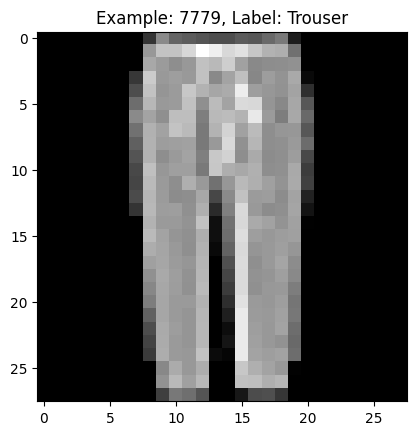

In [39]:
# define tensor to image transformation
trans = transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}'.format(str(image_id), fashion_classes[fashion_mnist_label]))

# plot mnist handwritten digit sample
plt.imshow(trans(fashion_mnist_image), cmap='gray')

That's it! In this lab, we will not use any test dataset. Unlike our previous labs where we built classifiers that required evaluation on test data, this lab does not utilize test data. We will train a model to generate new images, which, by definition, cannot be compared and validated against a test set. To train this lab's model, we will only use the training set of the `FashionMNIST` dataset, as it contains a sufficient number of images for our purposes.

## 4. Neural Network Implementation

In this section, we implement the architectures of the two **neural networks** that will constitute our **GAN** model. We aim to train our **GAN** to generate new images—artificial images based on the **FashionMNIST** dataset that no human has ever drawn, created, or dreamt of. Before we dive into the theory, let's briefly revisit the process to be established. The following illustration provides a bird's-eye view:

<img align="center" style="max-width: 800px" src="gan_pipeline.png">

We will build the two models that together constitute the **GAN** architecture. We will start with the construction of the `Discriminator` and then proceed to the `Generator`. After this, we will instantiate both models along with the other required components.


### 4.1 Implementing the Discriminator Network

The discriminative network $D$, which we name `Discriminator`, consists of four **fully-connected layers**. These layers aim to learn **non-linear feature combinations** that enable the detection of patterns. In fully-connected layers, all inputs are connected to all activation units of the next layer.

Let's implement the `Discriminator`. This is a binary classifier as described above. The input size to the first layer is 28x28 = 784, since our **FashionMNIST** images are 28x28 pixels. The output size of the last layer is 1, which corresponds to the model's classification of the input.

In [40]:
# implement the Discriminator network architecture
class Discriminator(nn.Module):

    # define the class constructor
    def __init__(self):

        # call super class constructor
        super(Discriminator, self).__init__()
        
        # specify fc layer 1: in 28*28, out 128
        self.fc1 = nn.Linear(28*28, 128) # the linearity W*x+b
        self.activation1 = nn.LeakyReLU(0.2, inplace=True) # the non-linearity
        
        # specify fc layer 2: in 128, out 64
        self.fc2 = nn.Linear(128, 64) # the linearity W*x+b
        self.activation2 = nn.LeakyReLU(0.2, inplace=True) # the non-linearity

        # specify fc layer 3: in 64, out 32
        self.fc3 = nn.Linear(64, 32) # the linearity W*x+b
        self.activation3 = nn.LeakyReLU(0.2, inplace=True) # the non-linearity
        
        # specify fc layer 4: in 32, out 1
        self.fc4 = nn.Linear(32, 1) # the linearity W*x+b

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
    # define network forward pass
    def forward(self, x):

        # flatten image
        x = x.view(-1, 28*28)

        # define fc layer 1 forward pass and add dropout
        x = self.activation1(self.fc1(x))
        x = self.dropout(x)

        # define fc layer 2 forward pass and add dropout
        x = self.activation2(self.fc2(x))
        x = self.dropout(x)

        # define fc layer 3 forward pass and add dropout
        x = self.activation3(self.fc3(x))
        x = self.dropout(x)
        
        # define fc layer 4 forward pass
        out = self.fc4(x)

        # return forward pass result
        return out

### 4.2 Implementing the Generator Network

Our generative network $G$, which we name `Generator`, consists of four **fully-connected layers**. These layers aim to learn **non-linear feature combinations** that enable the detection and, later, generation of patterns. In fully-connected layers, all inputs are connected to all activation units of the next layer.

In [41]:
# implement the Generator network architecture
class Generator(nn.Module):

    # define the class constructor
    def __init__(self):

        # call super class constructor
        super(Generator, self).__init__()
        
        # specify fc layer 1: in 100, out 32
        self.fc1 = nn.Linear(100, 32) # the linearity W*x+b
        self.activation1 = nn.LeakyReLU(0.2, inplace=True) # the non-linearity

        # specify fc layer 2: in 32, out 64
        self.fc2 = nn.Linear(32, 64) # the linearity W*x+b
        self.activation2 = nn.LeakyReLU(0.2, inplace=True) # the non-linearity

        # specify fc layer 3: in 64, out 128
        self.fc3 = nn.Linear(64, 128) # the linearity W*x+b
        self.activation3 = nn.LeakyReLU(0.2, inplace=True) # the non-linearity
        
        # specify fc layer 4: in 128, out 28*28
        self.fc4 = nn.Linear(128, 28*28) # the linearity W*x+b
       
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    # define network forward pass
    def forward(self, x):

        # define fc layer 1 forward pass and add dropout
        x = self.activation1(self.fc1(x))
        x = self.dropout(x)

        # define fc layer 2 forward pass and add dropout
        x = self.activation2(self.fc2(x))
        x = self.dropout(x)

        # define fc layer 3 forward pass and add dropout
        x = self.activation3(self.fc3(x))
        x = self.dropout(x)

        # define fc layer 4 with tanh applied
        out = self.fc4(x).tanh()

        # return forward pass result
        return out

You might notice that we use the `tanh` function as the last layer of our `Generator`. This is done because the `Discriminator` expects normalized input.

### 4.3 Generative Adversarial Network Model Instantiation

Now that we have implemented the GAN's `Discriminator` and `Generator` networks, we are ready to instantiate models of both for training.

In [42]:
D = Discriminator()
G = Generator()

Let's push the initialized `Discriminator` and `Generator` models to the enabled computing device:

In [43]:
D = D.to(device)
G = G.to(device)

Let's double-check if our model was deployed to the GPU, if available:

In [44]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


Once the models are initialized, we can visualize the model structures and review the implemented network architectures by executing the following cells. We start with the `Discriminator`:

In [45]:
print('[LOG] Discriminator architecture:\n\n{}\n'.format(D))

[LOG] Discriminator architecture:

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (activation1): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (activation2): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (activation3): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)



And now, let's review the `Generator`:

In [46]:
print('[LOG] Generator architecture:\n\n{}\n'.format(G))

[LOG] Generator architecture:

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (activation1): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (activation2): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (activation3): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)



Looks like it worked as intended? Brilliant! Finally, let's look into the number of model parameters that we aim to train in the next steps of the notebook. Again, we start with the `Discriminator`. The number of parameters, if everything is defined correctly, should be: 
$$(784+1) * 128 + (128+1) * 64 + (64+1) * 32 + (32+1) * 1 = 110,849$$

Don't hesitate to revisit our **CNN** lab if you are unsure how to count the number of parameters. Let's verify this calculation:

In [47]:
# init the number of model parameters
num_params_d = 0

# iterate over the distinct parameters
for param in D.parameters():

    # collect number of parameters
    num_params_d += param.numel()
    
# print the number of model paramters
print('[LOG] Number of Discriminator model parameters to be trained: {}.'.format(num_params_d))

[LOG] Number of Discriminator model parameters to be trained: 110849.


Now, let's look into the number of model parameters of the `Generator`. The number of parameters, if everything is defined correctly, should be: 
$$(100+1) * 32 + (32+1) * 64 + (64+1) * 128 + (128+1) * 784 = 114,800$$

Let's verify this calculation:

In [48]:
# init the number of model parameters
num_params_g = 0

# iterate over the distinct parameters
for param in G.parameters():

    # collect number of parameters
    num_params_g += param.numel()

# print the number of model paramters
print('[LOG] Number of Generator model parameters to be trained: {}.'.format(num_params_g))

[LOG] Number of Generator model parameters to be trained: 114800.


Okay, our 'simple' **GAN** model already encompasses an impressive number of parameters: 110,849 + 114,800 = **225,649** model parameters to be trained.

Now that we have implemented the GANs, we are ready to train the network. However, before starting the training, we need to define an appropriate loss function. Remember, we discussed in the theory section above (see 4.1.1) that we want to use **Binary Cross-Entropy (BCE)** loss with logits, so we do not have to manually define a sigmoid function in the network.

Let's instantiate the **BCEWithLogitsLoss** by executing the following PyTorch command:

In [49]:
# define the optimization criterion / loss function
criterion = nn.BCEWithLogitsLoss()

Next, let's also push the initialized `criterion` computation to the enabled computing `device`:

In [50]:
criterion = criterion.to(device)

Based on the loss magnitude of a certain mini-batch, PyTorch automatically computes the gradients. Even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$.

Based on the loss magnitude of a certain mini-batch, PyTorch automatically computes the gradients. Even better, based on the gradient, the library also helps us in the optimization and update of the network parameters $\theta$. We also set the learning rate to 0.02 for our **Discriminator** and to 0.002 for our **Generator**:

In [53]:
# set learning rate
d_lr = 0.02
g_lr = 0.002

Following the advice of [Soumith Chintala](https://github.com/soumith/ganhacks), we use the **Stochastic Gradient Descent** (`SGD`) optimizer for our **Discriminator**, and the `Adam` optimizer for our **Generator**. 

In [54]:
# create optimizers for the discriminator and generator
d_optimizer = optim.SGD(params=D.parameters(), lr=d_lr) 
g_optimizer = optim.Adam(params=G.parameters(), lr=g_lr) 

That's it! We are finally done with the implementation. Now, let's get down to training.

## 5. Neural Network Model Training

In this section, we will train a **Generative Adversarial Network (GAN)** model (as implemented in the section above) using the **FashionMNIST** images. Specifically, we will take a detailed look at the distinct training steps and how to monitor the training progress.

### 5.1 Preparing the Network Training

So far, we have pre-processed the dataset, implemented the GANs, and defined the loss function. Let's now start training the model for **20 epochs** with a **mini-batch size of 64** FashionMNIST images per batch. This means that the entire dataset will be fed through the network 20 times in chunks of 64 images, yielding **938 mini-batches** (60,000 images / 64 images per mini-batch) per epoch. After processing each mini-batch, the parameters of the network will be updated.

In [55]:
# specify the training parameters
num_epochs = 20 # number of training epochs
mini_batch_size=64 # size of the mini-batches

Furthermore, let's specify and instantiate a corresponding PyTorch data loader that feeds the image tensors to our neural network:

In [56]:
train_loader = torch.utils.data.DataLoader(fashion_mnist_data, batch_size=mini_batch_size, shuffle=True)

We can verify the length of the training `DataLoader`, which should correspond to **938 mini-batches**:

In [57]:
len(train_loader)

938

Please, remember that our `Discriminator` will attempt to classify samples as either *real* or *fake*. We therefore have to define what these labels will be.

As this is a binary classification task, we define:
>- $1$ as the label for real images: $y = 1$
>- $0$ as the label for fake images: $y = 0$

In [58]:
# establish convention for real and fake labels during training
real_label = 1
fake_label = 0

Lastly, we create a batch of **latent vectors**, exhibiting 100 dimensions each, that we will use later to visualize the progress of the `Generator`. We will call it `fixed_noise`, as it will remain fixed. This will allow us to take 4 images (we define a sample size of 4) and see how the results evolve in the evaluation section.

In [59]:
# define size of latent vector
z_size = 100

# define sample size
sample_size = 4

# uniformly distribute data of size z_size over an interval of -1; 1
fixed_noise = np.random.uniform(-1, 1, size=(sample_size, z_size))

# create numpy array into tensor, and convert data to float
fixed_noise = torch.from_numpy(fixed_noise).float()

# push the fixed vector to the device that's enabled
fixed_noise = fixed_noise.to(device)

### 5.2 Running the Network Training

Finally, we start training the model according to the following adversarial training protocol:

>1. Train the `Discriminator` on the real images.
>2. Generate fake images with the `Generator` and train the `Discriminator` on them.
>3. Perform a backward pass through the `Discriminator` and update its parameters $θ_{D}$.
>4. Train the `Generator` based on the `Discriminator`'s output on the fake data.
>5. Perform a backward pass through the `Generator` and update its parameters $θ_{G}$.


To ensure effective learning while training our **Generative Adversarial Network (GAN)** model, we will monitor whether the loss decreases as training progresses. Therefore, we will obtain and evaluate the performance on the entire training dataset after each iteration. Based on this evaluation, we can assess the training progress and determine whether the loss is converging, indicating that the model might not improve any further. The following elements of the network training code below should be given particular attention:

>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss.
>- `optimizer.step()` updates the network parameters based on the gradients.


In [60]:
# initialize list of the generated (fake) images
fake_images = []

# initialize collection of batch losses
D_batch_losses = []
G_batch_losses = []

# initialize collection of epoch losses
D_epoch_losses = []
G_epoch_losses = []

# set networks to training mode
D.train()
G.train()

# train the GANs
for epoch in range(num_epochs):
    D_batch_losses = []
    G_batch_losses = []

    # iterate over mini batches
    for i, data in enumerate(train_loader, 0):
        # define real images and push to computation device
        real_images = data[0].to(device)

        # define batch size as size of the images to make sure the loader is emptied completely
        batch_size = real_images.size(0)

        # --------------------------------------------------------------------------
        # (1) train Discriminator network
        # --------------------------------------------------------------------------

        #### train with real images

        # create tensor of same size as mini-batch and filled with 1's (real_label)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        # rescaling input images from [0,1) to [-1, 1), which is needed for network
        real_images = real_images * 2 - 1

        # run forward pass through Discriminator
        output = D(real_images).view(-1)

        # reset graph gradients
        D.zero_grad()

        # determine loss on Discriminator
        d_loss_real = criterion(output, label)

        # run backward pass
        d_loss_real.backward()
    
        #### train with fake images

        # generate batch of latent vectors
        z = np.random.uniform(-1, 1, size=(batch_size, z_size)) # torch.randn(batch_size, z_size, 1, 1, device=device)

        # create numpy array into tensor, and convert data to float
        z = torch.from_numpy(z).float()

        # push the z vector to the device that's enabled
        z = z.to(device)

        # generate fake image batch with Generator
        fake = G(z)

        # fills label tensor with 0's (fake_label)
        label.fill_(fake_label)

        # classify all fake batch with Discriminator
        output = D(fake.detach()).view(-1)

        # get discriminator loss on the fake batch
        d_loss_fake = criterion(output, label)

        # run backward pass
        d_loss_fake.backward()

        #### update Discriminator model parameters

        # compute error of Discriminator as sum of loss over the fake and the real batches
        d_loss = d_loss_fake + d_loss_real

        # update Discriminator parameters
        d_optimizer.step()

        # --------------------------------------------------------------------------
        # (2) train Generator network
        # --------------------------------------------------------------------------

        # reset graph gradients
        G.zero_grad()

        # fake labels are real for generator
        label.fill_(real_label)

        # since we just updated D, perform another forward pass of fake batch through the Discriminator
        output = D(fake).view(-1)

        # get Generator loss based on this output
        g_loss = criterion(output, label)

        # run backward pass
        g_loss.backward()

        #### update Generator model parameters

        # update Generator parameters
        g_optimizer.step()

        # --------------------------------------------------------------------------

        # case: 500 training iterations completed
        if i % 100 == 0:

            # print model training losses
            now = datetime.utcnow().strftime("%H:%M:%S")
            print(f'[LOG {now}] Epoch [{epoch+1}/{num_epochs}] [{i}/{len(train_loader)}] d_loss: {d_loss.item()} g_loss: {g_loss.item()}')
          
        # collect training losses
        D_batch_losses.append(d_loss.item())
        G_batch_losses.append(g_loss.item())

        # set Generator to eval mode for generating samples
        G.eval() 

        # make Generator generate samples from the fixed noise distribution
        samples = G(fixed_noise.float())

        # if you are using a GPU, copy tensor to host memory (cpu) - needed for later operations
        if device == 'cuda':

            # push samples to cpu
            samples = samples.cpu()

        # append generated fixed samples to the fake_images list
        fake_images.append(samples)

        # set Generator back to train mode
        G.train()

    # determine mean mini-batch loss of epoch
    D_epoch_loss = np.mean(D_batch_losses)
    G_epoch_loss = np.mean(G_batch_losses)

    D_epoch_losses.append(D_epoch_loss)
    G_epoch_losses.append(G_epoch_loss)

    # set filename of actual model
    d_model_name = f'gan_d_model_epoch_{epoch+1}.pth'
    g_model_name = f'gan_g_model_epoch_{epoch+1}.pth'

    # save current model to models directory
    torch.save(D.state_dict(), os.path.join(models_directory, d_model_name))
    torch.save(G.state_dict(), os.path.join(models_directory, g_model_name))

# open pickle file output stream
with open('fake_images.pkl', 'wb') as f:

    # save generated samples with pickle
    pkl.dump(fake_images, f)

[LOG 17:14:34] Epoch [1/20] [0/938] d_loss: 1.398045539855957 g_loss: 0.71001797914505
[LOG 17:14:34] Epoch [1/20] [100/938] d_loss: 1.3386313915252686 g_loss: 0.6965309977531433
[LOG 17:14:34] Epoch [1/20] [200/938] d_loss: 1.1460115909576416 g_loss: 1.1327106952667236
[LOG 17:14:34] Epoch [1/20] [300/938] d_loss: 0.9501237869262695 g_loss: 1.4340258836746216
[LOG 17:14:35] Epoch [1/20] [400/938] d_loss: 0.5705963373184204 g_loss: 2.4363152980804443
[LOG 17:14:35] Epoch [1/20] [500/938] d_loss: 0.6815137267112732 g_loss: 1.4285942316055298
[LOG 17:14:35] Epoch [1/20] [600/938] d_loss: 1.064985752105713 g_loss: 1.2472411394119263
[LOG 17:14:35] Epoch [1/20] [700/938] d_loss: 0.9194599390029907 g_loss: 1.418869137763977
[LOG 17:14:36] Epoch [1/20] [800/938] d_loss: 1.12582528591156 g_loss: 1.64384126663208
[LOG 17:14:36] Epoch [1/20] [900/938] d_loss: 1.1081550121307373 g_loss: 0.8532456755638123
[LOG 17:14:36] Epoch [2/20] [0/938] d_loss: 1.152795672416687 g_loss: 1.5915956497192383
[L

## 6. Generative Adversarial Network Model Evaluation

As we do not have a test set, the evaluation of a **Generative Adversarial Network (GAN)** model does not resemble that of a typical classifier. First, we base our evaluation on the progression of the losses of our two adversarial models. Then, and more interestingly, we examine the images generated by the `Generator` from the fixed noise we created. In this regard, you could say that the training and testing of the network happen simultaneously.

### 6.1 Training Loss Evaluation

Let's visualize and inspect the loss per training iteration (mini-batch). We'll start with the `Discriminator`'s loss:

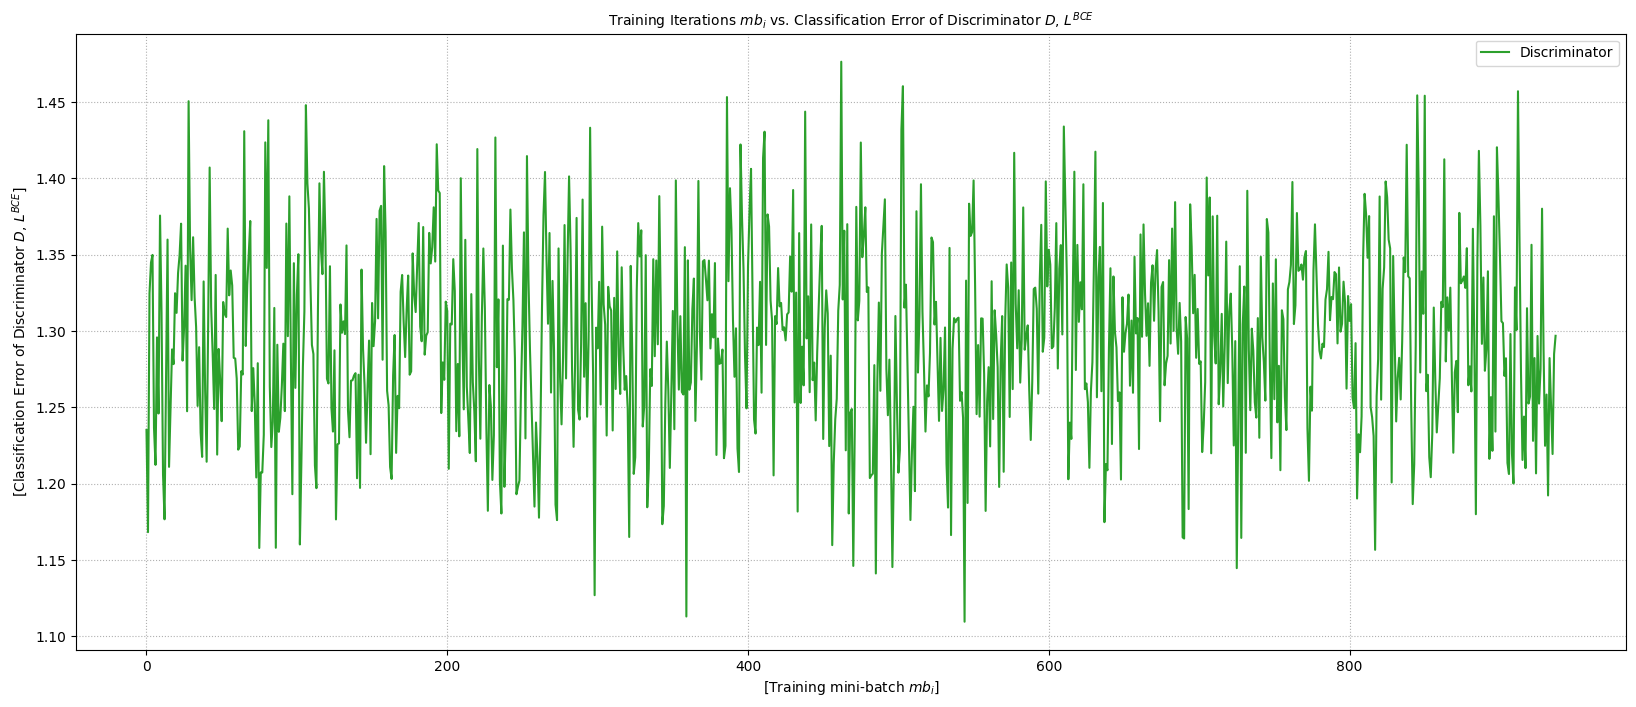

In [61]:
# prepare plot
fig, ax = plt.subplots(figsize=(20, 8))

# convert losses to numpy arrays
D_batch_losses = np.array(D_batch_losses)

# add grid
ax.grid(linestyle='dotted')

# plot losses of Discriminator and Generator
plt.plot(D_batch_losses, label='Discriminator', c = 'tab:green')

# add axis legends
ax.set_xlabel("[Training mini-batch $mb_i$]", fontsize=10)
ax.set_ylabel("[Classification Error of Discriminator $D$, $L^{BCE}$]", fontsize=10)

# add plot legends
plt.legend()

# add plot title
plt.title('Training Iterations $mb_i$ vs. Classification Error of Discriminator $D$, $L^{BCE}$', fontsize=10);

Now, let's visualize the `Generator`'s loss:

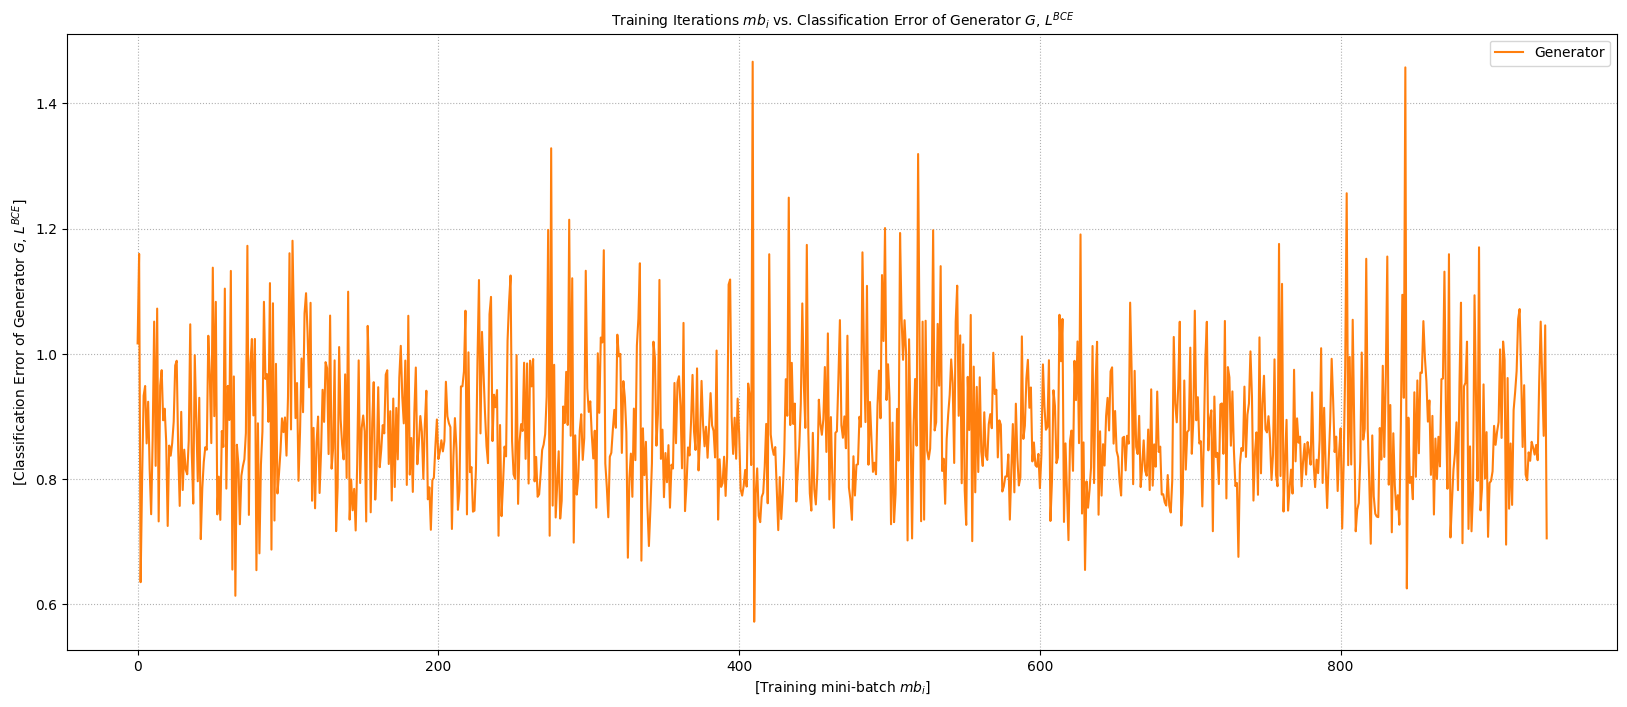

In [62]:
# prepare plot
fig, ax = plt.subplots(figsize=(20, 8))

# convert losses to numpy arrays
G_batch_losses = np.array(G_batch_losses)

# add grid
ax.grid(linestyle='dotted')

# plot losses of Discriminator and Generator
plt.plot(G_batch_losses, label='Generator', c = 'tab:orange')

# add axis legends
ax.set_xlabel("[Training mini-batch $mb_i$]", fontsize=10)
ax.set_ylabel("[Classification Error of Generator $G$, $L^{BCE}$]", fontsize=10)

# add plot legends
plt.legend()

# add plot title
plt.title('Training Iterations $mb_i$ vs. Classification Error of Generator $G$, $L^{BCE}$', fontsize=10);

What our batch losses seem to indicate is that although they are very fluctuating, the `Discriminator` starts off with a low loss which progressively increases, while the `Generator`'s loss decreases throughout the training. Let's plot the mean epoch losses of both models to get a clearer overview:

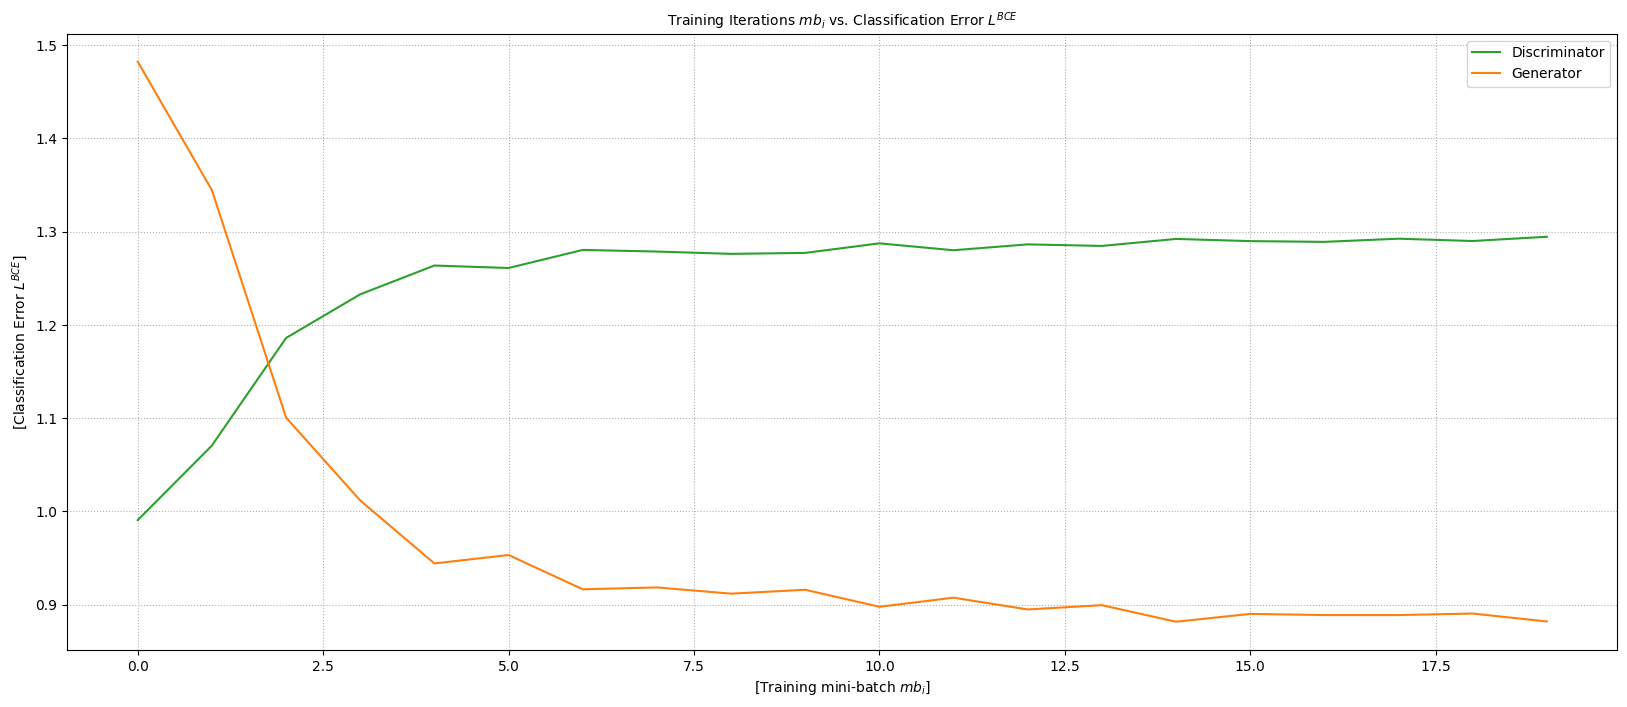

In [63]:
# prepare plot
fig, ax = plt.subplots(figsize=(20,8))

# convert losses to numpy arrays
D_epoch_losses = np.array(D_epoch_losses)
G_epoch_losses = np.array(G_epoch_losses)

# add grid
ax.grid(linestyle='dotted')

# plot losses of Discriminator and Generator
plt.plot(D_epoch_losses, label='Discriminator', c = 'tab:green')
plt.plot(G_epoch_losses, label='Generator', c = 'tab:orange')

# add axis legends
ax.set_xlabel("[Training mini-batch $mb_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $L^{BCE}$]", fontsize=10)

# add plot legends
plt.legend()

# add plot title
plt.title('Training Iterations $mb_i$ vs. Classification Error $L^{BCE}$', fontsize=10);

Okay, fantastic. The training error converges nicely for both networks. The `Discriminator` starts off strong during the first few epochs with a very low loss, while the `Generator` has a very high loss. It is very apparent that the `Generator` has no idea what to do at that point. Then, the trends change as the `Generator` gets better at knowing what fools the `Discriminator` — i.e., it gets better at faking images.

We see that the loss of the `Generator` is consistently a bit lower than that of the `Discriminator` after a few epochs. You could then hypothesize that the `Generator` is often able to fool the `Discriminator`.

### 6.2 Generated Images Evaluation

Let's now inspect the images that were generated during the training of our **Generative Adversarial Network (GAN)** model. To do so, we start by defining a function that we will use to display the generated samples. These samples were created using fixed noise, which helps us see the evolution of the `Generator`'s progress on a fixed distribution.

In [64]:
# create function to view the image samples
def view_samples(epoch, samples):

    # initialize plot
    fig, axes = plt.subplots(figsize=(10,7), nrows=1, ncols=4, sharey=True, sharex=True)
    
    # adjust padding between subplots
    fig.tight_layout(pad=5.0)

    # iterate over fake images at each epoch (we change epochs each 938 mini-batch)
    # remember, we save 4 images together at each iteration
    for i, (ax, img) in enumerate(zip(axes.flatten(), fake_images[epoch*938])):
        
        # create title for each subplot
        ax.set_title(f'Epoch {epoch+1}, Sample {i+1}')

        # detach image
        img = img.detach()

        # disable axes
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # show 28 by 28 grayscale image
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

We now "unpickle" the samples we saved using the `pickle` library:

In [65]:
# open pickle file input stream
with open('fake_images.pkl', 'rb') as f:

    # load generated samples with pickle
    samples = pkl.load(f)

We will call our function at each epoch to inspect the progress:

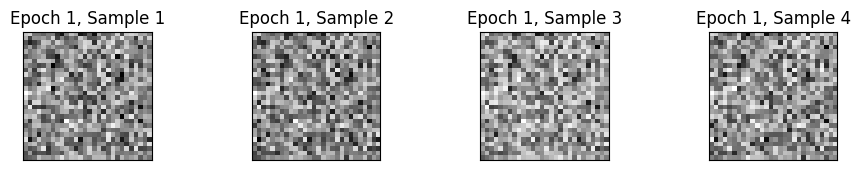

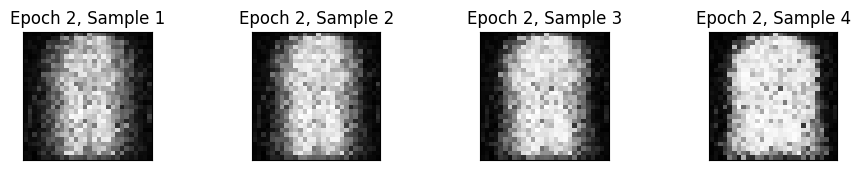

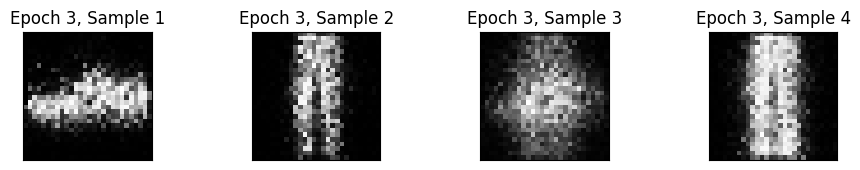

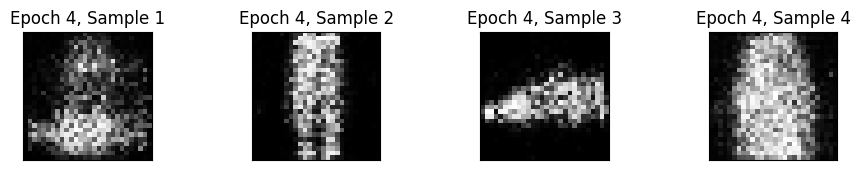

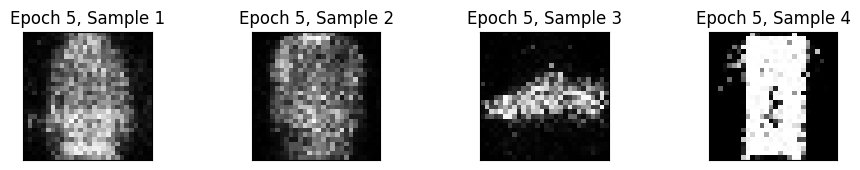

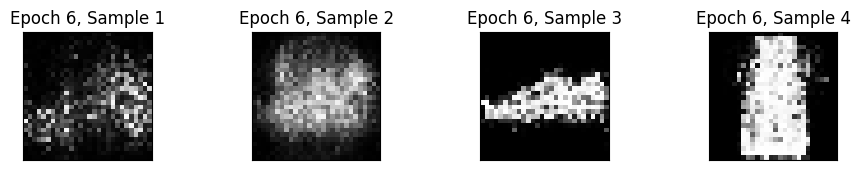

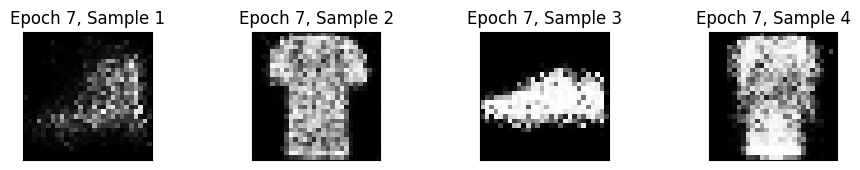

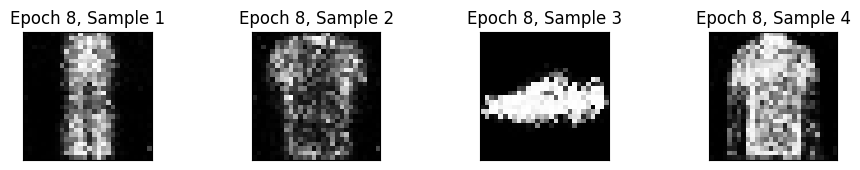

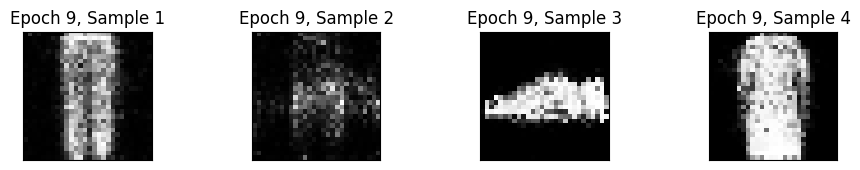

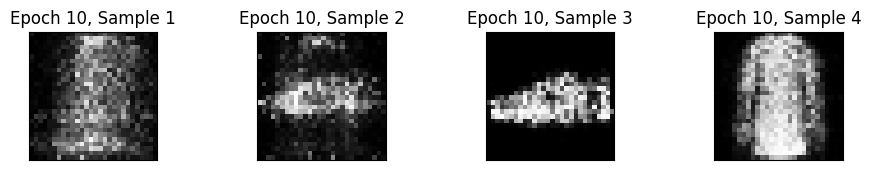

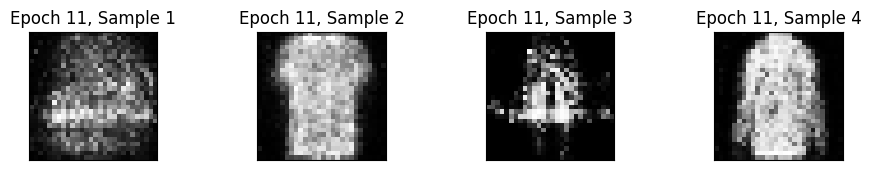

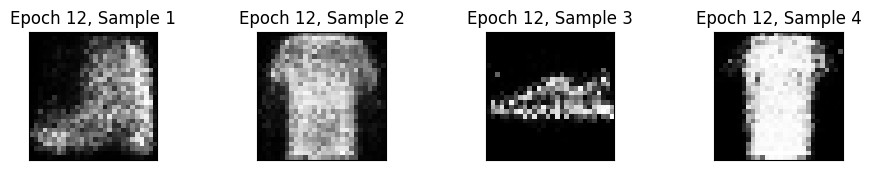

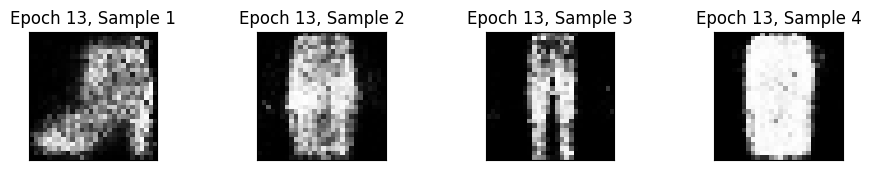

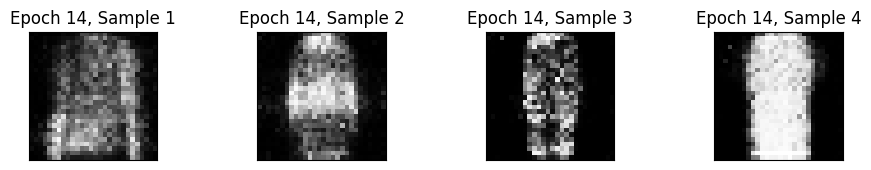

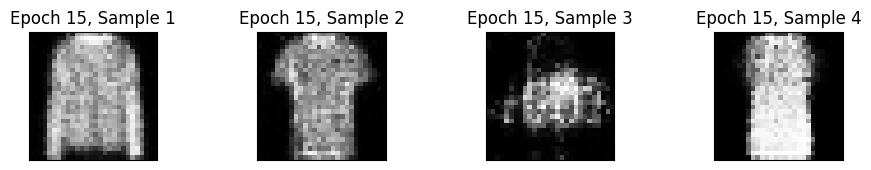

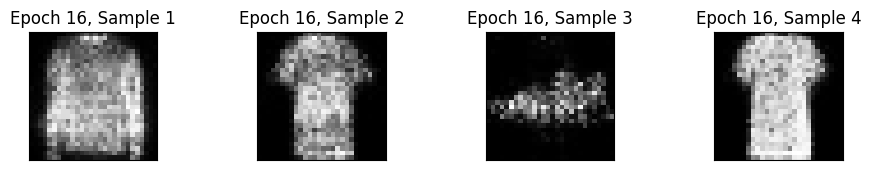

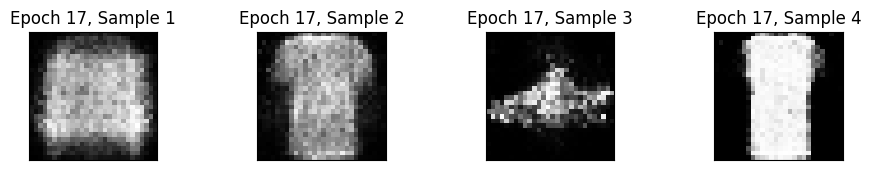

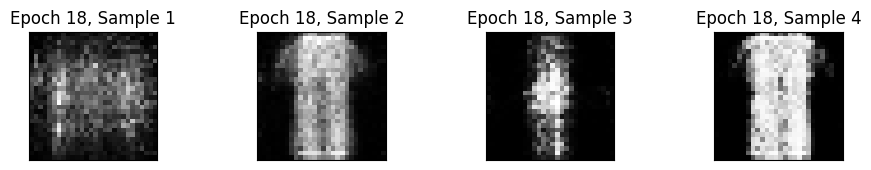

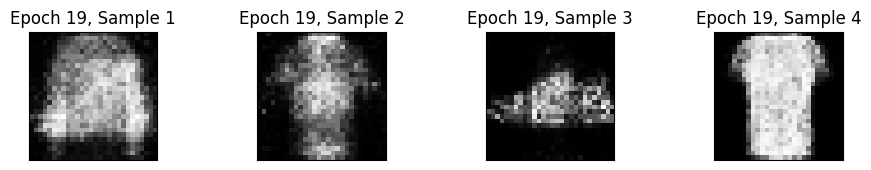

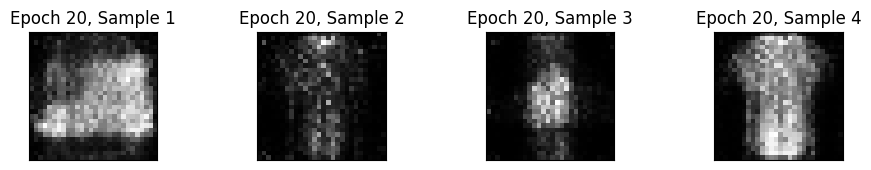

In [66]:
# iterate over epochs
for i in range(num_epochs):
  
    # call function to view the 4 samples
    view_samples(i, samples)

Cool, right? The samples generated by the `Generator` start off very poorly. They are totally random in the first epoch, and quite bad in the second—although we can witness clear progress. They then progressively improve, to the point where we can clearly see them representing clothes similar to those in the **FashionMNIST** dataset. The quality stabilizes over time. This rapid improvement and stabilization perfectly correspond to the progression of the `Generator`'s loss.

Interestingly, we sometimes see the same sample switching fashion class between epochs. As you can see, the model - whose parameters are updated at each iteration - does not care whether it outputs a shoe or a shirt; it simply aims at minimizing its loss.

## 8. Lab Summary:

In this lab, you successfully accomplished the following key learnings:

> 1. **Understanding GAN Architecture:** Mastered the fundamental concepts and architectural design of Generative Adversarial Networks (GANs), enhancing your comprehension of deep learning models tailored for generating synthetic data.
> 2. **Model Implementation and Training:** Developed practical skills in implementing and training a GAN model using PyTorch, applying it to the Fashion-MNIST dataset to generate realistic fashion images.
> 3. **Evaluating Model Performance:** Gained expertise in evaluating the performance of GAN models through metrics such as loss functions for both the generator and discriminator, and visually assessing the quality of generated images.
> 4. **Visualization and Interpretation of Generated Data:** Learned to visualize and interpret the generated fashion images, providing deeper insights into the model's ability to capture the underlying distribution of the training data.

This lab provided insights into designing, implementing, training, and evaluating GANs for generating synthetic data. It equipped you with tools and techniques for effective model building, evaluation, and application. These skills are invaluable for succeeding in deep learning.